# Prepare the Data 

In [1]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [2]:
import scipy.io
import numpy as np
import pandas as pd
from io import StringIO
from sklearn import datasets
from addutils import css_notebook
css_notebook()

In [3]:
import bokeh.plotting as bk
bk.output_notebook()

Loading BokehJS ...

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

## 1 Introduction: Building Good Training Sets

The quality of the data and the amount of useful information that it contains are key
factors that determine how well a machine learning algorithm performs. It is absolutely critical that we make sure to examine and preprocess a dataset before we feed it to a learning algorithm. In this notebook, we will show the essential data preprocessing steps that are useful to a ML pipeline:

- Removing and imputing missing values from the dataset
- Getting categorical data into shape for machine learning algorithms
- Selecting relevant features for the model construction

The first step in data analysis is usually 

## 2 Exploratory Data Analysis (EDA)

Most machine learning algorithms implemented in scikit-learn expect data to be stored in a
**two-dimensional array or matrix**.  The arrays can be
either ``numpy`` arrays, pandas ``DataFrame``, or in some cases ``scipy.sparse`` matrices.
The size of the array is expected to be `[n_samples, n_features]`

The number of features must be fixed in advance. However it can be very high dimensional
(e.g. millions of features) with most of them being zeros for a given sample. This is a case where `scipy.sparse` matrices can be useful, in that they are much more memory-efficient than numpy arrays.

Although it is not required, in many cases it can be easier to manage the data pre-processing with **pandas**. We use the *iris* dataset for this simple exploratory analysis.

Once we have loaded the dataset, we transform it to a Pandas DataFrame and then we can have a look at the first few columns (default to 5)

In [5]:
pd.options.display.notebook_repr_html = True
d = datasets.load_iris()
df = pd.DataFrame(d.data, columns=d.feature_names)
df['y'] = d.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


It is usually wise to look at the dimension of the DataFrame, and the name of the columns.

In [6]:
print(df.shape)
print(df.columns)

(150, 5)
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'y'],
      dtype='object')


Next, we can look at summary of numerical features by using `describe` function. It provides count, mean, standard deviation (std), min, quartiles and max as output.

In [7]:
pd.set_option('precision',3)
df.drop('y', axis=1).describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000,150.000,150.000,150.000
mean,5.843,3.054,3.759,1.199
std,0.828,0.434,1.764,0.763
min,4.300,2.000,1.000,0.100
25%,5.100,2.800,1.600,0.300
50%,5.800,3.000,4.350,1.300
75%,6.400,3.300,5.100,1.800
max,7.900,4.400,6.900,2.500


For non-numerical values we can look at frequency distribution to understand whether they make sense or not. The frequency table can be printed by the command `value_counts` (in this case the only discrete variable we have is the output `y`). 

In [8]:
df['y'].value_counts()

2    50
1    50
0    50
Name: y, dtype: int64

`value_counts` works only on `pandas.Series` objects (i.e. only on columns). Another method is to convert the target column to a category and then use the `describe` function. Note however that `descibe` exclude categorical columns by default.

In [9]:
df['y'] = df['y'].astype('category')
df['y'].describe()

count     150
unique      3
top         2
freq       50
Name: y, dtype: int64

Next we can see a two dimensional plot. On the x and y axes you can choose whatever feature to plot, while the color of the dot represents the label.

In [10]:
x_feat, y_feat = 2, 3 # Choose the features to plot (0-3)
fig = bk.figure(title=None, plot_width=600, plot_height=500)
colors = ['#006CD1', '#26D100', '#D10000']
color_series = [ colors[i] for i in df['y'] ]
fig.scatter(df[df.columns[x_feat]], df[df.columns[y_feat]], 
            line_color=None, fill_color=color_series,
            radius=0.08)
fig.xaxis.axis_label = df.columns[x_feat]
fig.yaxis.axis_label = df.columns[y_feat]

bk.show(fig)

Pandas contains some utility functions and plotting functions that can help in previewing the data. In this case we use a `scatter_matrix` pandas plot to plot the four features one versus the other:

<IPython.core.display.Javascript object>


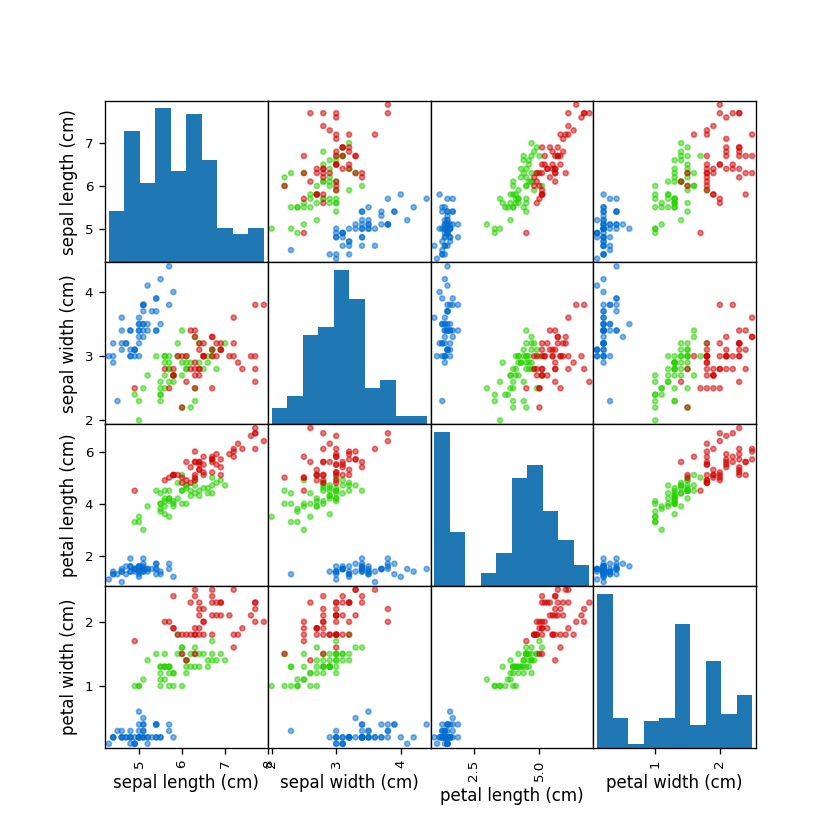

In [11]:
pd.tools.plotting.scatter_matrix(df[df.columns[:4]], figsize=(7, 7),
                                 c=color_series, diagonal='hist', marker='.')
plt.show()

This is an example of a scatterplot matrix. Each variable is plotted against each other. For example, the middle square in the first column is an individual scatterplot of `petal lenght` and `sepal lenght`, with `petal lenght` as the X-axis and `sepal lenght` as the Y-axis. This same plot is replicated in the middle of the top row. In essence, the boxes on the upper right hand side of the whole scatterplot are mirror images of the plots on the lower left hand. The diagonal line can be choosen to be either histogram or density of the variable at hand.

If we would like to change the histogram, for example by changing the number of bins, we cal draw single features with the function `hist`

<IPython.core.display.Javascript object>


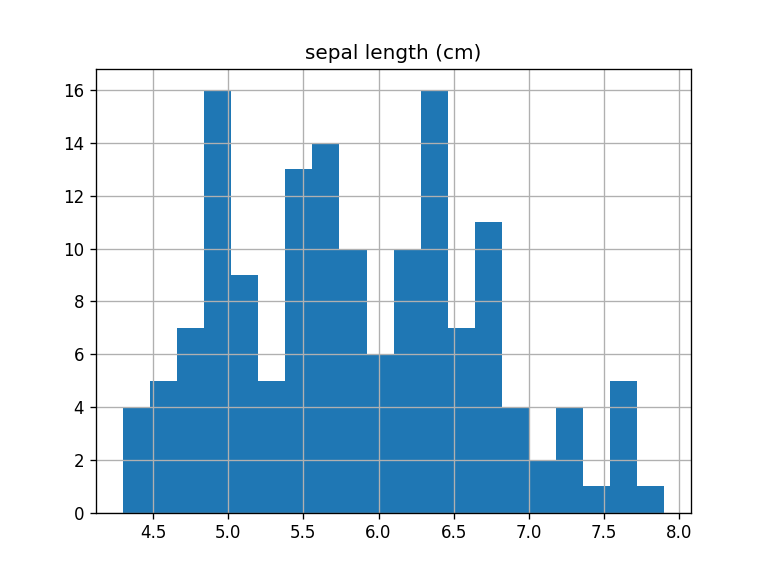

In [12]:
df.hist('sepal length (cm)', bins=20)
plt.show()

Alternatively we can also plot an estimated density of the distribution.

<IPython.core.display.Javascript object>


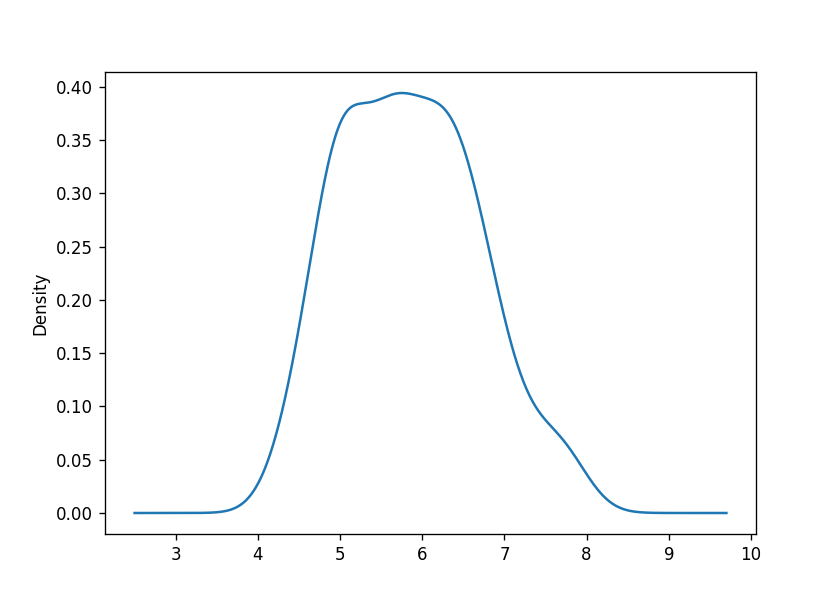

In [13]:
fig = plt.figure(figsize=(7,5))
ax = df['sepal length (cm)'].plot.kde()
fig.axes.append(ax)
fig.show()

Next, we look at box plots to understand the distributions. Box plot for fare can be plotted by `boxplot` function.

<IPython.core.display.Javascript object>


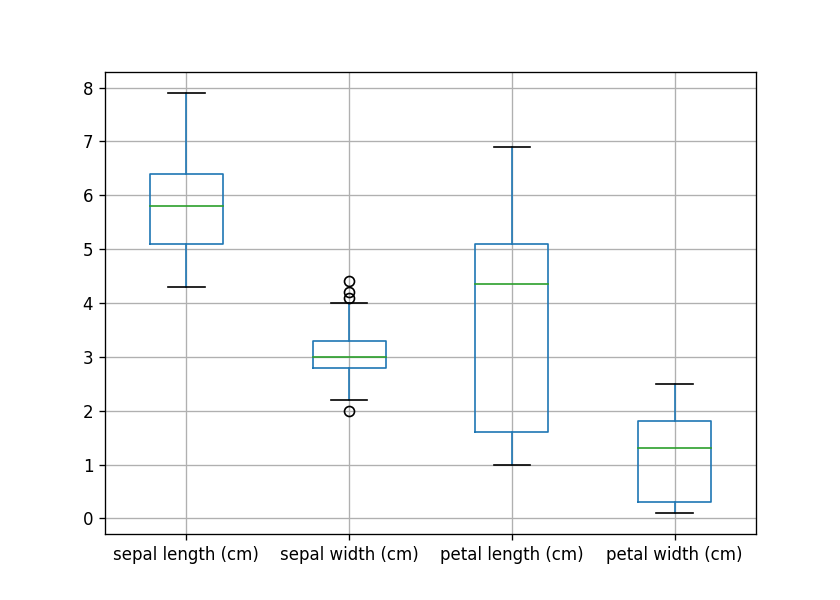

In [14]:
fig = plt.figure(figsize=(7,5))
ax = df.boxplot(['sepal length (cm)', 'sepal width (cm)', 
                 'petal length (cm)', 'petal width (cm)'])
fig.axes.append(ax)
fig.show()

The box plot (a.k.a. box and whisker diagram) is a standardized way of displaying the distribution of data based on the five number summary: minimum, first quartile, median, third quartile, and maximum. In the simplest box plot the central rectangle spans the first quartile to the third quartile (the interquartile range or IQR). A segment inside the rectangle shows the median and "whiskers" above and below the box show the locations of the minimum and maximum. 

This simplest possible box plot displays the full range of variation (from min to max), the likely range of variation (the IQR), and a typical value (the median). Not uncommonly real datasets will display surprisingly high maximums or surprisingly low minimums called outliers. John Tukey has provided a precise definition for two types of outliers:

- Outliers are either 3×IQR or more above the third quartile or 3×IQR or more below the first quartile.

- Suspected outliers are are slightly more central versions of outliers: either 1.5×IQR or more above the third quartile or 1.5×IQR or more below the first quartile. 

If either type of outlier is present the whisker on the appropriate side is taken to 1.5×IQR from the quartile (the "inner fence") rather than the max or min, and individual outlying data points are displayed as unfilled circles (for suspected outliers) or filled circles (for outliers). (The "outer fence" is 3×IQR from the quartile.) 

Although scikit-learn was developed for working with NumPy arrays, it can sometimes be more  convenient to preprocess data using pandas' DataFrame. We can always access the underlying NumPy array of the DataFrame via the values attribute before we feed it into a scikit-learn estimator:

In [15]:
df.values[:5]

array([[5.1, 3.5, 1.4, 0.2, 0],
       [4.9, 3.0, 1.4, 0.2, 0],
       [4.7, 3.2, 1.3, 0.2, 0],
       [4.6, 3.1, 1.5, 0.2, 0],
       [5.0, 3.6, 1.4, 0.2, 0]], dtype=object)

## 3 Missing Data

It is not uncommon in real-world applications that our samples are missing one
or more values for various reasons. There could have been an error in the data
collection process, certain measurements are not applicable, particular fields could
have been simply left blank in a survey, for example. We typically see missing
values as the blank spaces in our data table or as placeholder strings such as NaN
(Not A Number).

Unfortunately, most computational tools are unable to handle such missing values
or would produce unpredictable results if we simply ignored them. Therefore, it
is crucial that we take care of those missing values before we proceed with further
analyses. But before we discuss several techniques for dealing with missing values,
let's create a simple example data frame.

In [16]:
df = pd.DataFrame(np.random.randn(10,5), columns=list('ABCDE'))
#let's put some NaNs
nans = np.vstack([np.random.choice(10, size=10), 
                  np.random.choice(5, size=10)]).T
for el in nans:
    df.iloc[el[0], el[1]] = np.nan
df

,A,B,C,D,E
0,NaN,-1.311,NaN,-1.032,NaN
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,NaN
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,NaN,0.062,2.841,1.417,NaN
7,NaN,-1.964,-1.984,0.593,-0.427
8,NaN,-1.125,-0.236,-0.306,-0.504
9,NaN,-0.476,-0.291,-0.277,0.236


Using the preceding code, we read CSV-formatted data into a pandas DataFrame
via the read_csv function and noticed that the two missing cells were replaced by
NaN . The StringIO function in the preceding code example was simply used for the
purposes of illustration. It allows us to read the string assigned to csv_data into a
pandas DataFrame as if it was a regular CSV file on our hard drive.

For a larger DataFrame , it can be tedious to look for missing values manually; in this
case, we can use the isnull method to return a DataFrame with Boolean values that
indicate whether a cell contains a numeric value ( False ) or if data is missing ( True ).
Using the sum method, we can then return the number of missing values per column
as follows:

In [17]:
df.isnull().sum()

A    5
B    0
C    1
D    0
E    3
dtype: int64

In [18]:
df.isnull().sum().sum()

9

This way, we can count the number of missing values per column; in the following subsections, we will take a look at different strategies for how to deal with this missing data.

### 3.1 Removal

One of the easiest ways to deal with missing data is to simply remove the corresponding features (columns) or samples (rows) from the dataset entirely; rows with missing values can be easily dropped via the dropna method:

In [19]:
df.dropna()

,A,B,C,D,E
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203


Similarly, we can drop columns that have at least one NaN in any row by setting the axis argument to 1 :

In [20]:
df.dropna(axis=1)

,B,D
0,-1.311,-1.032
1,0.604,-1.012
2,-1.452,0.275
3,-0.007,-1.822
4,-0.065,0.472
5,-1.126,-1.052
6,0.062,1.417
7,-1.964,0.593
8,-1.125,-0.306
9,-0.476,-0.277


The dropna method supports several additional parameters that can come in handy:    

- Only drop rows where all columns are NaN

In [21]:
df.dropna(how='all')

,A,B,C,D,E
0,NaN,-1.311,NaN,-1.032,NaN
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,NaN
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,NaN,0.062,2.841,1.417,NaN
7,NaN,-1.964,-1.984,0.593,-0.427
8,NaN,-1.125,-0.236,-0.306,-0.504
9,NaN,-0.476,-0.291,-0.277,0.236


- drop rows that have not at least 4 non-NaN values

In [22]:
df.dropna(thresh=4)

,A,B,C,D,E
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,NaN
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
7,NaN,-1.964,-1.984,0.593,-0.427
8,NaN,-1.125,-0.236,-0.306,-0.504
9,NaN,-0.476,-0.291,-0.277,0.236


- only drop rows where NaN appear in specific columns (here: 'C')

In [23]:
df.dropna(subset=['C'])

,A,B,C,D,E
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,NaN
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,NaN,0.062,2.841,1.417,NaN
7,NaN,-1.964,-1.984,0.593,-0.427
8,NaN,-1.125,-0.236,-0.306,-0.504
9,NaN,-0.476,-0.291,-0.277,0.236


Although the removal of missing data seems to be a convenient approach, it also comes with certain disadvantages; for example, we may end up removing too many samples, which will make a reliable analysis impossible. Or, if we remove too many feature columns, we will run the risk of losing valuable information that our classifier needs to discriminate between classes. In the next section, we will thus look at one of the most commonly used alternatives for dealing with missing values: interpolation techniques.

### 3.2 Imputation

Often, the removal of samples or dropping of entire feature columns is simply not feasible, because we might lose too much valuable data. In this case, we can use different interpolation techniques to estimate the missing values from the other training samples in our dataset. One of the most common interpolation techniques is mean imputation, where we simply replace the missing value by the mean value of the entire feature column. A convenient way to achieve this is by using the Imputer class from scikit-learn, as shown in the following code:

In [24]:
from sklearn.preprocessing import Imputer
imr = Imputer(missing_values='NaN', strategy='mean', axis=0)
imr = imr.fit(df)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 0.58320777, -1.31115661, -0.31904043, -1.03157355,  0.43951792],
       [ 0.65760368,  0.60377238,  1.11821952, -1.01175369,  0.8072781 ],
       [ 1.04654807, -1.45241333, -0.25506716,  0.27481352,  1.68583554],
       [-0.47515821, -0.0068532 , -1.69229552, -1.82177617,  0.43951792],
       [-1.07646358, -0.06537348, -2.12309326,  0.47189816, -0.92422873],
       [ 2.76350888, -1.12622475, -0.24929568, -1.05150964,  2.20282507],
       [ 0.58320777,  0.06154832,  2.8405581 ,  1.41723101,  0.43951792],
       [ 0.58320777, -1.96365272, -1.98353439,  0.59344346, -0.42669577],
       [ 0.58320777, -1.12517884, -0.23574985, -0.30611291, -0.50400515],
       [ 0.58320777, -0.47584863, -0.29110564, -0.27739664,  0.23561634]])

Here, we replaced each NaN value by the corresponding mean, which is separately calculated for each feature column. If we changed the setting axis=0 to axis=1 , we'd calculate the row means. Other options for the strategy parameter are median or most_frequent , where the latter replaces the missing values by the most frequent values. This is useful for imputing categorical feature values. 

Pandas has its own ways ot impute values. The fillna function can "fill in" NA values with non-null data in a couple of ways:

In [25]:
df.fillna(0)

,A,B,C,D,E
0,0.000,-1.311,0.000,-1.032,0.000
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,0.000
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,0.000,0.062,2.841,1.417,0.000
7,0.000,-1.964,-1.984,0.593,-0.427
8,0.000,-1.125,-0.236,-0.306,-0.504
9,0.000,-0.476,-0.291,-0.277,0.236


Fill gaps forward or backward, we can propagate non-null values forward or backward:

In [26]:
df.ffill()

,A,B,C,D,E
0,NaN,-1.311,NaN,-1.032,NaN
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,1.686
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,2.764,0.062,2.841,1.417,2.203
7,2.764,-1.964,-1.984,0.593,-0.427
8,2.764,-1.125,-0.236,-0.306,-0.504
9,2.764,-0.476,-0.291,-0.277,0.236


In [27]:
df.bfill()

,A,B,C,D,E
0,0.658,-1.311,1.118,-1.032,0.807
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,-0.924
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,NaN,0.062,2.841,1.417,-0.427
7,NaN,-1.964,-1.984,0.593,-0.427
8,NaN,-1.125,-0.236,-0.306,-0.504
9,NaN,-0.476,-0.291,-0.277,0.236


Both Series and Dataframe objects have an interpolate method that, by default, performs linear interpolation at missing datapoints.

In [28]:
df.interpolate()

,A,B,C,D,E
0,NaN,-1.311,NaN,-1.032,NaN
1,0.658,0.604,1.118,-1.012,0.807
2,1.047,-1.452,-0.255,0.275,1.686
3,-0.475,-0.007,-1.692,-1.822,0.381
4,-1.076,-0.065,-2.123,0.472,-0.924
5,2.764,-1.126,-0.249,-1.052,2.203
6,2.764,0.062,2.841,1.417,0.888
7,2.764,-1.964,-1.984,0.593,-0.427
8,2.764,-1.125,-0.236,-0.306,-0.504
9,2.764,-0.476,-0.291,-0.277,0.236


## 4 Feature Engineering

This section is about changing the dataset to meet model requirements. For example the majority of machine learning and optimization algorithms behave much better if features are on the same scale

### 4.1 Standardizing = Mean Removal + Variance Scaling:

Standardization of datasets is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like *standard normally distributed data*: Gaussian with zero mean and unit variance. In practice we often ignore the shape of the distribution and just transform the data to center and scale by dividing by the standard deviation.

*If the input variables are combined via a distance function* (such as Euclidean distance), standardizing inputs can be crucial. If
one input has a range of 0 to 1, while another input has a range of 0 to 1,000,000, then the contribution of the first input to the distance will be swamped by the second input.

It is sometimes not enough to center and scale the features independently, since a downstream model can further make some assumption on the linear independence of the features. To address this issue you can use `sklearn.decomposition.PCA` or `sklearn.decomposition.RandomizedPCA` with `whiten=True` to further remove the linear correlation across features.

`scale` and `StandardScaler` work out-of-the-box with 1d arrays. 

`preprocessing.scale` scales each column of the features matric to **mean=0 and std=1**. This is also called **"STANDARDIZATION"**.

In [29]:
from sklearn import preprocessing
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.]])

In [30]:
X_sc_1 = preprocessing.scale(X)
print(X)
print('\nScaled Values: ')
print(X_sc_1)

[[ 10.   1.   0.]
 [ 20.   0.   2.]]

Scaled Values: 
[[-1.  1. -1.]
 [ 1. -1.  1.]]


`preprocessing.StandardScaler` keeps the values of `.mean_` and `.std_` to allow lately `transform` and `inverse_transform` **mean** and **std** scaling can be controlled independently:

In [31]:
scaler = preprocessing.StandardScaler(copy=True, with_mean=True, with_std=True)
scaler.fit(X)
X_sc_2 = scaler.transform(X)
print('\nScaled Values: ')
print(X_sc_2)
print('\nStandard Scaler Mean: ', scaler.mean_)
print('Standard Scaler Std:  ', scaler.scale_)
print('\nInverse Transform: ')
print(scaler.inverse_transform(X_sc_2))


Scaled Values: 
[[-1.  1. -1.]
 [ 1. -1.  1.]]

Standard Scaler Mean:  [ 15.    0.5   1. ]
Standard Scaler Std:   [ 5.   0.5  1. ]

Inverse Transform: 
[[ 10.   1.   0.]
 [ 20.   0.   2.]]


### 4.2 Using the preprocessing.StandardScaler with pandas:

In [32]:
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.]])
df = pd.DataFrame(X)
df

,0,1,2
0,10.0,1.0,0.0
1,20.0,0.0,2.0


In [33]:
df.describe().ix[[1,2]]

,0,1,2
mean,15.000,0.500,1.000
std,7.071,0.707,1.414


In [34]:
scaler = preprocessing.StandardScaler(copy=False, with_mean=True, with_std=True).fit(df)
print('\nStandard Scaler Mean: ', scaler.mean_)
print('Standard Scaler Std:  ', scaler.scale_)
df_sc_2 = pd.DataFrame(scaler.transform(df))
df_sc_2


Standard Scaler Mean:  [ 15.    0.5   1. ]
Standard Scaler Std:   [ 5.   0.5  1. ]


,0,1,2
0,-1.0,1.0,-1.0
1,1.0,-1.0,1.0


In [35]:
df_inv =  pd.DataFrame(scaler.inverse_transform(df_sc_2))
df_inv

,0,1,2
0,10.0,1.0,0.0
1,20.0,0.0,2.0


### 4.3 Normalizing = Dividing by a Norm of the Vector:

`preprocessing.normalize` sets thenorm of the vector =1.

By default `(axis=1)`, so if it's necessary to normalize the columns  and not the rows, `axis` must be set to 0.

In [36]:
X = np.array([[ 10.,  1., 0.],
              [ 20.,  0., 2.],
              [ 20.,  0., 0.]])
X_nrm = preprocessing.normalize(X, norm='l2', axis=0)
print('\nNormalized Values: ')
print(X_nrm)


Normalized Values: 
[[ 0.33333333  1.          0.        ]
 [ 0.66666667  0.          1.        ]
 [ 0.66666667  0.          0.        ]]


## 5 Features Selection

Finding a good data representation is very domain specific and related to available measurements. 

Human expertise, which is often required to convert "raw" data into a set of useful features, can be complemented by automatic feature construction methods. In some approaches, feature construction is integrated in the modeling process. For examples the hidden layers of a Deep Neural Network compute internal representations someway analogous to constructed features. In other approaches, feature construction is a preprocessing step that must be perform in order for the algorithm to perform well.

We have already seen two examples of feature engineering that regards standardization and normalization. 

### 5.1 Derived Features (feature construction)

Features extraction (module `sklearn.feature_extraction`) consists in transforming arbitrary data, such as text or images, into numerical features usable for machine learning.

Derived features are obtained by pre-processing the data to generate features that are somehow more informative.  Derived features may be linear or nonlinear combinations of features (such as in Polynomial regression), or may be some more sophisticated transform of the features.  The latter is often used in image processing.

For example, [scikit-image](http://scikit-image.org/) provides a variety of feature
extractors designed for image data: see the ``skimage.feature`` submodule. 

Derived features may include:

- *Signal enhancement:* the signal-to-noise ratio may be improved by applying signal or image-processing filters. These operations include baseline or background removal, de-noising, smoothing, or sharpening. The Fourier transform and wavelet transforms are popular methods

- *Extraction of local features:* For sequential, spatial or other structured data, specific techniques like convolutional methods using hand-crafted kernels or syntactic and structural methods are used. These techniques encode problem specific knowledge into the features. 

- *Linear and non-linear space embedding methods:* When the dimensionality of the data is very high, some techniques might be used to project or embed the data into a lower dimensional space while retaining as much information as possible. Classical examples are Principal Component Analysis (PCA) and Multidimensional Scaling (MDS). The coordinates of the data points in the lower dimension space might be used as features or simply as a means of data visualization.

- *Non-linear expansions:* Although dimensionality reduction is often summoned when speaking about complex data, it is sometimes better to increase the dimensionality. This happens when the problem is very complex and first order interactions are not enough to derive good results. 

- *Categorical Data Enconding*: how do we treat categorical data? Some algorithms cannot use data where a ordering realtion is not clear or not present!

How do we know when a feature is relevant or informative? This is what "feature selection" is about.

### 5.2 One-hot encoding of categorical features:

Often features are not given as continuous values but categorical. For example a person could have features ["male", "female"], ["from Europe", "from US", "from Asia"], ["uses Firefox", "uses Chrome", "uses Safari", "uses Internet Explorer"]. Such features can be efficiently coded as integers, for instance ["male", "from US", "uses Internet Explorer"] could be expressed as [0, 1, 3] while ["female", "from Asia", "uses Chrome"] would be [1, 2, 1].

Such integer representation can not be used directly with scikit-learn estimators, as these expect continuous input, and would interpret the categories as being ordered, which is often not desired (i.e. the set of browsers was ordered arbitrarily).

One possibility to convert categorical features to features that can be used with scikit-learn estimators is to use a one-of-K or one-hot encoding, which is implemented in OneHotEncoder. This estimator transforms each categorical feature with m possible values into m binary features, with only one active.

In [37]:
data_in = np.array([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
print(data_in)

[[0 0 3]
 [1 1 0]
 [0 2 1]
 [1 0 2]]


In [38]:
enc = preprocessing.OneHotEncoder()
enc.fit(data_in)  

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [39]:
enc.transform(data_in).toarray()

array([[ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.]])

In [40]:
enc.transform([[0, 1, 3]]).toarray()

array([[ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]])

`DictVectorizer` implements what is called one-of-K or “one-hot” coding for categorical (aka nominal, discrete) features, without the need to first transform the variables from text to categorical.

In the following code the method `vec.fit_transform(temp)` returns a sparse matrix that is tranformed to dense by `.toarray()`.

In [41]:
from sklearn.feature_extraction import DictVectorizer, text
t = [{'city': 'Dubai', 'temperature': 33.},
     {'city': 'London', 'temperature': 12.},
     {'city': 'San Fransisco', 'temperature': 18.},]

pd.DataFrame(t)

,city,temperature
0,Dubai,33.0
1,London,12.0
2,San Fransisco,18.0


In [42]:
vec = DictVectorizer()
t_vec = vec.fit_transform(t)
df = pd.DataFrame(t_vec.toarray(), columns=vec.get_feature_names())
df

,city=Dubai,city=London,city=San Fransisco,temperature
0,1.0,0.0,0.0,33.0
1,0.0,1.0,0.0,12.0
2,0.0,0.0,1.0,18.0


### 5.3 The Bag of Words representation:

Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

In order to address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

- tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
- counting the occurrences of tokens in each document.
- normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.

In this scheme, features and samples are defined as follows:

- each individual token occurrence frequency (normalized or not) is treated as a feature.
- the vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call **vectorization** the general process of turning a collection of text documents into numerical feature vectors. *This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation*. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

`CountVectorizer` implements both tokenization and occurrence counting in a single class:

In [43]:
#feature_extraction.text.CountVectorizer?

In [44]:
corpus = ['This is the x-first document.', 'This is the second second document.',
          'And the third third third one.', 'Is this the first document?']
vec = text.CountVectorizer()
X = vec.fit_transform(corpus)
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
df

,and,document,first,is,one,second,the,third,this
0,0,1,1,1,0,0,1,0,1
1,0,1,0,1,0,2,1,0,1
2,1,0,0,0,1,0,1,3,0
3,0,1,1,1,0,0,1,0,1


The default configuration tokenizes the string by extracting words of at least 2 letters. The specific function that does this step can be requested explicitly:

In [45]:
analyzer = vec.build_analyzer()
analyzer("This is the x-first document.")

['this', 'is', 'the', 'first', 'document']

 Words that were not seen in the training corpus will be completely ignored in future calls to the transform method:

In [46]:
print(vec.transform(['Something completely new.']).toarray())

[[0 0 0 0 0 0 0 0 0]]


Note that in the previous corpus we lose the information that the last document is an interrogative form because each word is encoded individually. To preserve the local ordering information we can extract 2-grams of words in addition to the 1-grams (the word themselves):

In [47]:
vec_bi = text.CountVectorizer(min_df=1, ngram_range=(1, 2))
X_bi = vec_bi.fit_transform(corpus)
pd.set_option('display.max_columns', None)
df_bi = pd.DataFrame(X_bi.toarray(), columns=vec_bi.get_feature_names())
df_bi

,and,and the,document,first,first document,is,is the,is this,one,second,second document,second second,the,the first,the second,the third,third,third one,third third,this,this is,this the
0,0,0,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0
1,0,0,1,0,0,1,1,0,0,2,1,1,1,0,1,0,0,0,0,1,1,0
2,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,3,1,2,0,0,0
3,0,0,1,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1


In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information. For this reason  it is very common to use the `tf–idf` (term-frequency / inverse document-frequency) transform: each row is normalized to have unit euclidean norm. The weights of each feature computed by the fit method call are stored in a model attribute:

In [48]:
corpus2 = [ 'aa aa cc dd', 'aa cc',
           'aa bb cc ff', "aa aa"]
tfidf = text.TfidfVectorizer()
X = tfidf.fit_transform(corpus2)
print(X.toarray())

[[ 0.66052121  0.          0.40395613  0.63287533  0.        ]
 [ 0.63295194  0.          0.77419109  0.          0.        ]
 [ 0.31878155  0.61087812  0.38991559  0.          0.61087812]
 [ 1.          0.          0.          0.          0.        ]]


Check scikit-learn documentation for additional information on feature extraction.

### 5.4 Feature Hashing

The idea is very simple: convert data into a vector of features. When this is done using hashing we call the method "feature hashing" or "the hashing trick".

I'll explain how it works with a simple example using text as data.

Let's say our text is:

"the quick brown fox"

We would like to represent this as a vector. The first thing we need is to fix the length of the vector, the number of dimensions, we are going to use, let's say we would like to use 5 dimensions.

Once we fix the number of dimensions we need a hash function that will take a string and return a number between 0 and n-1, in our case between 0 and 4. Any good hash function can be used and you just use h(string) mod n to make it return a number between 0 and n-1.

I'll invent the results for each word in our text:

h(the) mod 5 = 0<br>
h(quick) mod 5 = 1<br>
h(brown) mod 5 = 1<br>
h(fox) mod 5 = 3<br>

Once we have this we can simply construct our vector as:

(1,2,0,1,0)

Notice that we just add 1 to the nth dimension of the vector each time our hash function returns that dimension for a word in the text.

And that's feature hashing or "the hashing trick". You can skip the rest but I can’t resist giving up a few extra pointers:

* In general the number of dimensions we use for our vectors can be VERY large, for example 225 or similar.

* The vectors will be very sparse so store them in a format that saves space, for example one vector for the values that are not zero and another vector for the column number for each of those values.

* It is possible to use a 2nd hash function that returns +1 or -1 to decide if you add or substract from the vector. This will minimize collisions making a dimension of the vector taking a very large value.

Implements feature hashing, aka the hashing trick.

This class turns sequences of symbolic feature names (strings) into scipy.sparse matrices, using a hash function to compute the matrix column corresponding to a name. The hash function employed is the signed 32-bit version of Murmurhash3.

Feature names of type byte string are used as-is. Unicode strings are converted to UTF-8 first, but no Unicode normalization is done. Feature values must be (finite) numbers.

This class is a low-memory alternative to DictVectorizer and CountVectorizer, intended for large-scale (online) learning and situations where memory is tight, e.g. when running prediction code on embedded devices.

In [49]:
from sklearn.feature_extraction import FeatureHasher
n_features = 4
hasher = FeatureHasher(n_features=n_features, input_type="string")
X = hasher.transform(corpus)
X.toarray()

array([[ 5., -8.,  0.,  0.],
       [ 4., -9.,  0.,  4.],
       [ 3., -5.,  1.,  3.],
       [ 5., -4.,  0., -2.]])

### 5.5 Feature Extraction

In preceding paragraphs we used hand-crafted features as additional features. There are other automated ways to perform this kind of task. Automated feature selection, can be used for: 
- *dimensionality reduction*
- *performance improvement*
- *data understanding*

we will briefly sketch the main ideas of these approaches because some of the methods require particular algorithms that will be explained in future sections. We will highlight each of those during the explanation of each algorithm. 

In general there are three kind of automated feature extraction methods:
- *filter methods:* use of statistical methods to rank feature based on some metric or score.
- *wrapper methods:* utilize a learning machine as a "black box" to score subsets of features according to their predictive power with different models.
- *embedded methods:* perform feature selection in the process of training and are usually specific to given machine learning algorithm.

#### 5.5.1 Recursive Feature Elimination

This is an example of a wrapper method. This is an example of a *backward selection strategy* called Recursive Feature Elimination. We'll use an algoirthm called SVM (it will be the main topic of another notebook don't worry if you don't understand how it works), that will try to predict the target having decision function $f(x) = w^Tx + b$, the
method iteratively removes the feature $x_i$ with the smallest weight in absolute value $\mid w_i \mid$ and retraining the model. At the expense of some sub-optimality, the method can be sped up by removing several features at a time at each iteration. The method can also be extended to the non-linear SVM and other methods as well.

Optimal number of features : 3


<IPython.core.display.Javascript object>


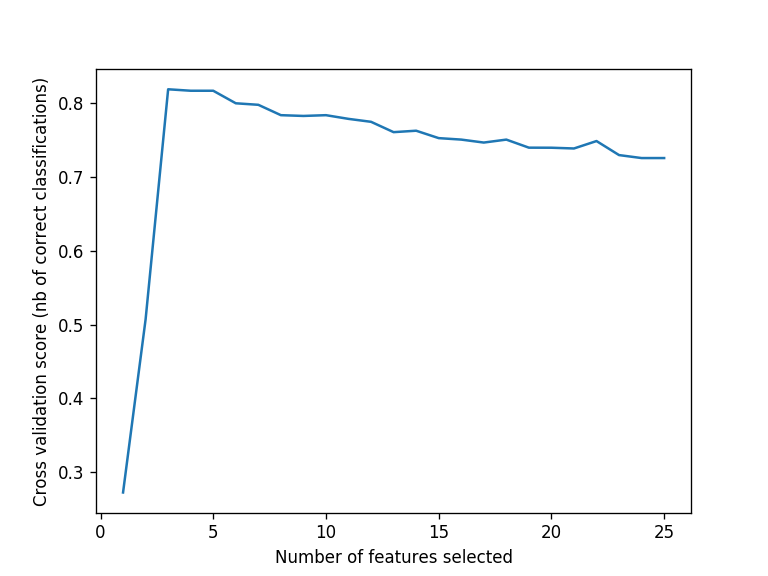

In [50]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

---

Visit [www.add-for.com](<http://www.add-for.com/IT>) for more tutorials and updates.

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.